***Imports & Data Cleaning***

In [10]:
import pandas as pd
import numpy as np

# load
df = pd.read_csv('adult 3.csv')

# mark “?” missing
df.replace('?', np.nan, inplace=True)

# drop & fill
df = df.dropna(subset=['native-country'])
df['workclass']    = df['workclass'].fillna('Unknown')
df['occupation']   = df['occupation'].fillna('Unknown')

# drop redundant
df = df.drop(columns=['fnlwgt','education'])

# clean target
df['income'] = df['income'].str.strip().map({'<=50K':0,'>50K':1})
df = df.dropna(subset=['income'])
df['income'] = df['income'].astype(int)

print("Shape after cleaning:", df.shape)
df.head()

Shape after cleaning: (47985, 13)


,age,workclass,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,Unknown,10,Never-married,Unknown,Own-child,White,Female,0,0,30,United-States,0


***Baseline Logistic Regression***

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# features
num_cols = ['age','educational-num','capital-gain','capital-loss','hours-per-week']
cat_cols = ['workclass','marital-status','occupation',
            'relationship','race','gender','native-country']

X = df[num_cols+cat_cols]
y = df['income']

X_train,X_test,y_train,y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# pipeline
preproc = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])
lr_pipe = Pipeline([('prep',preproc),('clf',LogisticRegression(max_iter=1000))])

lr_pipe.fit(X_train,y_train)
y_pred = lr_pipe.predict(X_test)

print("LR Accuracy:", accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

LR Accuracy: 0.8471397311659894
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      7304
           1       0.72      0.58      0.65      2293

    accuracy                           0.85      9597
   macro avg       0.80      0.76      0.77      9597
weighted avg       0.84      0.85      0.84      9597



***Random Forest Baseline***

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline([
    ('prep', preproc),
    ('clf', RandomForestClassifier(
        n_estimators=100, class_weight='balanced',
        n_jobs=-1, random_state=42
    ))
])

rf_pipe.fit(X_train,y_train)
y_pred_rf = rf_pipe.predict(X_test)

print("RF Accuracy:", accuracy_score(y_test,y_pred_rf))
print(classification_report(y_test,y_pred_rf))

RF Accuracy: 0.8418255704907783
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      7304
           1       0.68      0.64      0.66      2293

    accuracy                           0.84      9597
   macro avg       0.78      0.77      0.78      9597
weighted avg       0.84      0.84      0.84      9597



***Random Forest Hyperparameter Tuning***

***XGBoost***

In [15]:
from xgboost import XGBClassifier

xgb_pipe = Pipeline([
    ('prep', preproc),
    ('clf', XGBClassifier(
        n_estimators=100, learning_rate=0.1,
        max_depth=5, use_label_encoder=False,
        eval_metric='logloss', n_jobs=-1, random_state=42
    ))
])

xgb_pipe.fit(X_train,y_train)
y_pred_xgb = xgb_pipe.predict(X_test)

print("XGB Accuracy:", accuracy_score(y_test,y_pred_xgb))
print(classification_report(y_test,y_pred_xgb))

XGB Accuracy: 0.8676669792643534
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      7304
           1       0.78      0.62      0.69      2293

    accuracy                           0.87      9597
   macro avg       0.83      0.78      0.80      9597
weighted avg       0.86      0.87      0.86      9597



***Compare Models and Identify Best Performer***

In [16]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Dictionary of fitted pipelines
models = {
    'LogisticRegression': lr_pipe,
    'RandomForest': rf_pipe,
    'XGBoost': xgb_pipe
}

# Compute metrics for each model
metrics = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    metrics.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred)
    })

metrics_df = pd.DataFrame(metrics).set_index('Model')
print(metrics_df)

# Identify best model by F1-score
best_model_name = metrics_df['F1'].idxmax()
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name} (F1 = {metrics_df.loc[best_model_name,'F1']:.3f})")

# Show the first 10 predictions of the best model on X_test
best_preds = best_model.predict(X_test)
print("\nFirst 10 predictions of the best model:", best_preds[:10])

                    Accuracy  Precision    Recall        F1
Model                                                      
LogisticRegression  0.847140   0.723243  0.583515  0.645909
RandomForest        0.841826   0.678325  0.642826  0.660099
XGBoost             0.867667   0.782441  0.617968  0.690546

Best model: XGBoost (F1 = 0.691)

First 10 predictions of the best model: [0 0 1 0 1 0 0 0 0 0]


***Plot ROC and Precision-Recall Curves***

<Figure size 800x600 with 0 Axes>

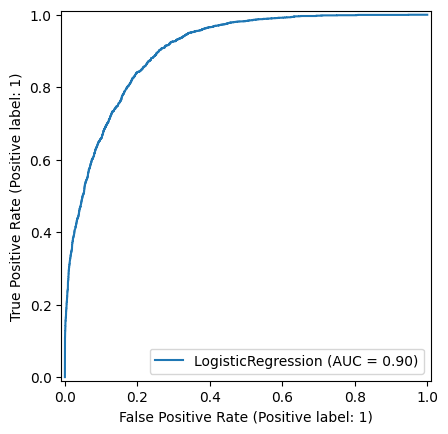

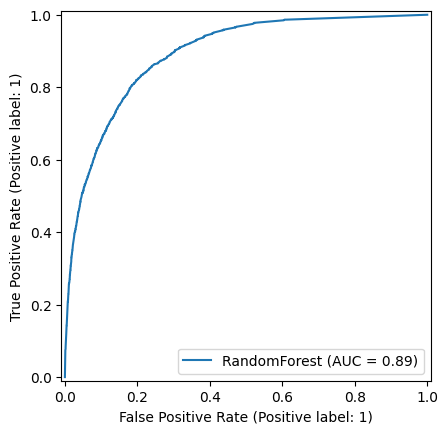

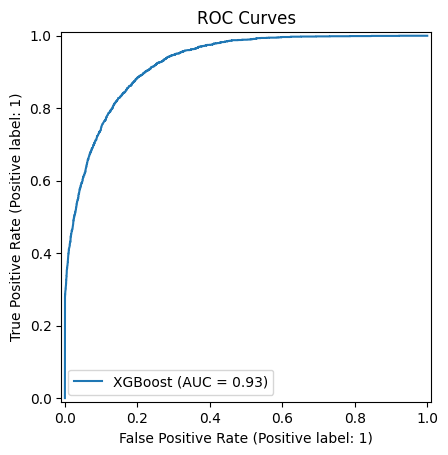

<Figure size 800x600 with 0 Axes>

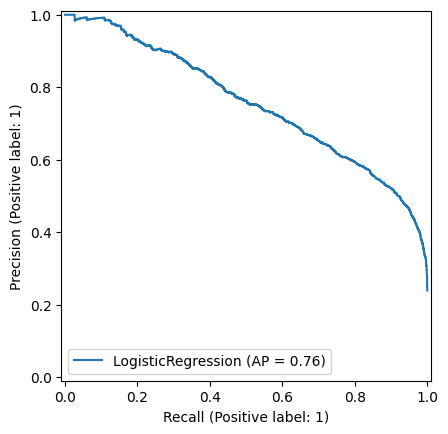

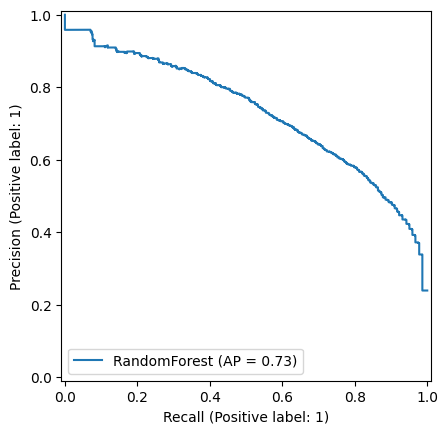

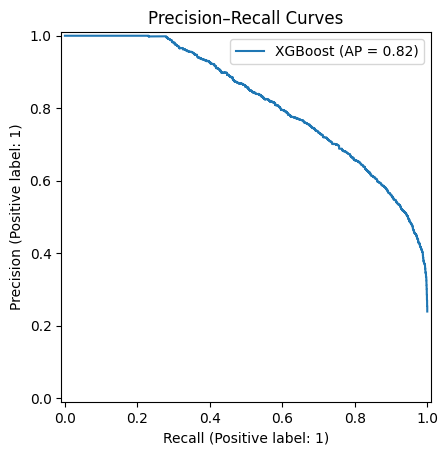

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    RocCurveDisplay.from_predictions(y_test, y_prob, name=name)
plt.title('ROC Curves')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    PrecisionRecallDisplay.from_predictions(y_test, y_prob, name=name)
plt.title('Precision–Recall Curves')
plt.legend()
plt.show()

***Top 10 XGBoost Feature Importances***

In [18]:
import numpy as np

# Build feature names list (numeric + one-hot)
ohe_names = xgb_pipe.named_steps['prep'] \
    .named_transformers_['cat'] \
    .get_feature_names_out(cat_cols)
feature_names = num_cols + list(ohe_names)

# Get importances and display top 10
importances = xgb_pipe.named_steps['clf'].feature_importances_
indices = np.argsort(importances)[::-1][:10]

print("Top 10 XGBoost Features:")
for idx in indices:
    print(f"  {feature_names[idx]}: {importances[idx]:.4f}")

Top 10 XGBoost Features:
  marital-status_Married-civ-spouse: 0.4458
  educational-num: 0.0612
  capital-gain: 0.0442
  occupation_Other-service: 0.0434
  occupation_Exec-managerial: 0.0422
  relationship_Own-child: 0.0266
  occupation_Prof-specialty: 0.0238
  capital-loss: 0.0209
  occupation_Sales: 0.0169
  age: 0.0150


***Final summary of predictions and notation***

In [19]:

# 1. Label mapping
print("Label mapping:")
print("  0 ➔ salary <=50K")
print("  1 ➔ salary >50K\n")

# 2. Best model
print(f"Best model selected: {best_model_name}\n")

# 3. Sample predictions on the test set
print("Sample predictions (first 10) of the best model:")
print(best_preds[:10], "\n")

# 4. Overall prediction distribution
import pandas as pd
pred_counts = pd.Series(best_preds).value_counts().sort_index()
print("Prediction counts on test set:")
print(f"  0 (<=50K): {pred_counts[0]} samples")
print(f"  1 (>50K) : {pred_counts[1]} samples\n")

# 5. Evaluation metrics notation
print("Evaluation metrics notation:")
print("  Accuracy  = (TP + TN) / Total")
print("  Precision = TP / (TP + FP)")
print("  Recall    = TP / (TP + FN)")
print("  F1-score  = 2 * (Precision * Recall) / (Precision + Recall)\n")

# 6. Print metrics for each model
print("Model performance on test set:")
for model_name, row in metrics_df.iterrows():
    print(f"  {model_name}: "
          f"Accuracy={row['Accuracy']:.3f}, "
          f"Precision={row['Precision']:.3f}, "
          f"Recall={row['Recall']:.3f}, "
          f"F1={row['F1']:.3f}")

Label mapping:
  0 ➔ salary <=50K
  1 ➔ salary >50K

Best model selected: XGBoost

Sample predictions (first 10) of the best model:
[0 0 1 0 1 0 0 0 0 0] 

Prediction counts on test set:
  0 (<=50K): 7786 samples
  1 (>50K) : 1811 samples

Evaluation metrics notation:
  Accuracy  = (TP + TN) / Total
  Precision = TP / (TP + FP)
  Recall    = TP / (TP + FN)
  F1-score  = 2 * (Precision * Recall) / (Precision + Recall)

Model performance on test set:
  LogisticRegression: Accuracy=0.847, Precision=0.723, Recall=0.584, F1=0.646
  RandomForest: Accuracy=0.842, Precision=0.678, Recall=0.643, F1=0.660
  XGBoost: Accuracy=0.868, Precision=0.782, Recall=0.618, F1=0.691
